In [44]:
import e2h
import ops
import numpy as np
import nkutil
import netket as nk
from scipy.optimize import minimize
import inspect

cnn_j2s = []
cnn_anisos = []
cnn_dj2s = []
cnn_ediff = []
cnn_overlap_vr = []
cnn_overlap_ve = []
cnn_overlap_er = []
cnn_var_reg = []
cnn_var_recons = []
cnn_recons_gap = []
cnn_exact_gap = []
cnn_ediff_recons = []

regular_gap = []
degen_gap = []
degen_var = []
degen_dj2 = []
degen_j3 = []

e2h.disable_print = True

cnn_file = "cnn_exact/j1_1_j2_{0}.wf"
for j2 in ['0.0', '0.1', '0.2', '0.3', '0.4', '0.45', '0.5', '0.55', '0.6', '0.65', '0.75', '0.85', '1.0', '1.25', '1.5', '1.75', '2.0']:
    data = e2h.main(['python3 e2h.py', '4x4', '-machine_type', 'j1j2_exact', '-ops_dist', '2', '-ham_j2', j2, '-machine_from_file', cnn_file.format(j2), '-meas_full_sample', '1', '-meas_full_sample_sym_c4', '1', '-meas_full_sample_sym_t', '1', '-ops_symmetries', 'trans_x,trans_y,rot', '-meas_wf_rotation', 'neel' if float(j2) <= 0.5 else 'striped', '-ops_only_aniso', '6'])
    cnn_j2s.append(float(j2))
    cnn_anisos.append(data['eigens'][0]['h'][2])
    cnn_dj2s.append(data['eigens'][0]['h'][1])
    
    exact_h = nkutil.reconstructed_ham(data['hi'], data['rotate_sites'], data['operators'], [1, 0, 0])
    exact_gs = nk.exact.lanczos_ed(exact_h, first_n=2, compute_eigenvectors=True)
    recons_h = nkutil.reconstructed_ham(data['hi'], data['rotate_sites'], data['operators'], data['eigens'][0]['h'] / data['eigens'][0]['h'][0])
    recons_gs = nk.exact.lanczos_ed(recons_h, first_n=2, compute_eigenvectors=True)
    
    cnn_wf = e2h.extract_wavefunction(data['cfg'], data['hi'], exact_h, data['ffnn'], data['lat'], character=(1, -1) if float(j2) > 2 else (1, 1))
    cnn_ediff.append(np.real(np.vdot(cnn_wf, exact_h.to_sparse() * cnn_wf)) - exact_gs.eigenvalues[0])
    cnn_ediff_recons.append(np.real(np.vdot(cnn_wf, recons_h.to_sparse() * cnn_wf)) - recons_gs.eigenvalues[0])
    
    cnn_overlap_vr.append(np.abs(np.vdot(cnn_wf, recons_gs.eigenvectors[0])) ** 2)
    cnn_overlap_er.append(np.abs(np.vdot(exact_gs.eigenvectors[0], recons_gs.eigenvectors[0])) ** 2)
    cnn_overlap_ve.append(np.abs(np.vdot(cnn_wf, exact_gs.eigenvectors[0])) ** 2)
    regular_gap.append(data['eigens'][1]['variance'] - data['eigens'][0]['variance'])
    cnn_var_reg.append(ops.braket_variance(data['Q'], [1, 0, 0]))
    cnn_var_recons.append(ops.braket_variance(data['Q'], data['eigens'][0]['h']))
    print(cnn_var_reg[-1], cnn_var_recons[-1])
    cnn_exact_gap.append(exact_gs.eigenvalues[1] - exact_gs.eigenvalues[0])
    cnn_recons_gap.append(recons_gs.eigenvalues[1] - recons_gs.eigenvalues[0])
    
    data = e2h.main(['python3 e2h.py', '4x4', '-machine_type', 'j1j2_exact', '-ops_dist', '2', '-ham_j2', j2, '-machine_from_file', cnn_file.format(j2), '-meas_full_sample', '1', '-meas_full_sample_sym_c4', '1', '-meas_full_sample_sym_t', '1', '-ops_symmetries', 'trans_x,trans_y,rot', '-meas_wf_rotation', 'neel' if float(j2) <= 0.5 else 'striped', '-ops_only_aniso', '5'])
    degen_gap.append(data['eigens'][1]['variance'] - data['eigens'][0]['variance'])
    degen_var.append(ops.braket_variance(data['Q'], [1/(1+float(j2)**2), float(j2)/(1+float(j2)**2), 0, 0]))
    degen_dj2.append(data['eigens'][0]['h'][1] / data['eigens'][0]['h'][0] - float(j2))
    degen_j3.append(data['eigens'][0]['h'][3] / data['eigens'][0]['h'][0])


0.024217924895083343 0.02419933943400293
0.020508725377339942 0.020489884992859878
0.04131241036338906 0.04126223546778475
0.08409181135289145 0.08395792935874517
0.2064339114442646 0.20588647708278335
0.34668727272742217 0.3432652938627245
0.7153062724246411 0.6865841902878692
1.0940931540342262 0.966207129423791
0.4855618678184328 0.4528451619382793
0.3086354290157942 0.298893544620744
0.5107884515387013 0.4963790670185072
0.6948427014508525 0.6757608813382848
0.4224610095166099 0.4140801562515484
0.6443031158423764 0.642107969796118
0.7106883268752426 0.7095875389188431
0.1676842874749127 0.16679653861710478
0.25407095759328513 0.25301958387209394


In [7]:
rbm_j2s = []
rbm_anisos = []
rbm_dj2s = []
rbm_ediff = []
rbm_overlap_vr = []
rbm_overlap_ve = []
rbm_overlap_er = []
    
rbm_file = "rbm/rbm_alpha_10_j1_1_j2_{0}.wf"
for j2 in ['0.0', '0.1', '0.2', '0.3', '0.4', '0.45', '0.5', '0.55', '0.6', '0.75', '1.0', '1.25', '1.5', '1.75']:
    rbm_j2s.append(float(j2))
    
    data = e2h.main(['python3 e2h.py', '4x4', '-machine_type', 'rbms', '-machine_rbms_alpha', '10', '-ops_dist', '2', '-ham_j2', j2, '-machine_from_file', rbm_file.format(j2), '-meas_full_sample', '1', '-meas_full_sample_sym_c4', '1', '-meas_full_sample_sym_t', '1', '-ops_symmetries', 'trans_x,trans_y,rot', '-ops_only_aniso', '6'])
    rbm_anisos.append(data['eigens'][0]['h'][2])
    rbm_dj2s.append(data['eigens'][0]['h'][1])
    
    exact_h = nkutil.reconstructed_ham(data['hi'], data['rotate_sites'], data['operators'], [1, 0, 0])
    exact_gs = nk.exact.lanczos_ed(exact_h, first_n=2, compute_eigenvectors=True)
    recons_h = nkutil.reconstructed_ham(data['hi'], data['rotate_sites'], data['operators'], data['eigens'][0]['h'] / data['eigens'][0]['h'][0])
    recons_gs = nk.exact.lanczos_ed(recons_h, first_n=2, compute_eigenvectors=True)
    
    rbm_wf = e2h.extract_wavefunction(data['cfg'], data['hi'], exact_h, data['ffnn'], data['lat'], character=(1, -1) if float(j2) > 2 else (1, 1))
    print(np.real(np.vdot(rbm_wf, exact_h.to_sparse() * rbm_wf)), exact_gs.eigenvalues[0])
    rbm_ediff.append(np.real(np.vdot(rbm_wf, exact_h.to_sparse() * rbm_wf)) - exact_gs.eigenvalues[0])
    
    rbm_overlap_vr.append(np.abs(np.vdot(rbm_wf, recons_gs.eigenvectors[0])) ** 2)
    rbm_overlap_er.append(np.abs(np.vdot(exact_gs.eigenvectors[0], recons_gs.eigenvectors[0])) ** 2)
    rbm_overlap_ve.append(np.abs(np.vdot(rbm_wf, exact_gs.eigenvectors[0])) ** 2)
    
    data = e2h.main(['python3 e2h.py', '4x4', '-machine_type', 'rbms', '-machine_rbms_alpha', '10', '-ops_dist', '2', '-ham_j2', j2, '-machine_from_file', rbm_file.format(j2), '-meas_full_sample', '1', '-meas_full_sample_sym_c4', '1', '-meas_full_sample_sym_t', '1', '-ops_symmetries', 'trans_x,trans_y,rot', '-ops_only_aniso', '5'])
    

-44.91225425142025 -44.913932833715386
-42.20906231086762 -42.22829900607506
-39.66794132647532 -39.67193225791438
-37.25713810489999 -37.31096503551978
-35.19911174996469 -35.27345745284241
-34.38539033593477 -34.45118744807641
-33.74868353188028 -33.83169340557943
-33.42900667911512 -33.5100523289333
-33.574572339916706 -33.65733260896091
-37.97122252243503 -38.03347739849483
-49.143814743449006 -49.18196086441013
-60.83956420436667 -60.86660484022526
-72.66979692815977 -72.68993438690795
-84.5611272560614 -84.57483153641599


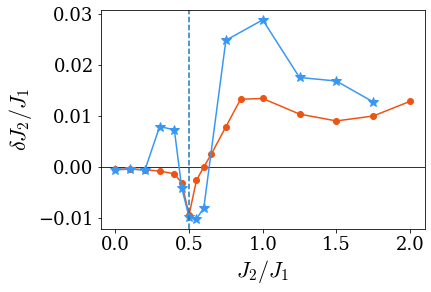

In [52]:
import matplotlib.pyplot as plt 
color1 = "#ee5312"
color2 = "#3897f5"
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 18}
import matplotlib
matplotlib.rc('font', **font)
matplotlib.rc('mathtext', fontset='cm')

fig, ax = plt.subplots(1, 1, figsize=[6, 4])
ax.axhline(0, lw=0.8, color="black")
ax.plot(cnn_j2s, cnn_dj2s, 'o-', color=color1, label='CNN')
ax.plot(rbm_j2s, rbm_dj2s, '*-', color=color2, label='RBM', markersize=10)
ax.set_xlabel("$J_2/J_1$", fontsize=22)
ax.set_ylabel("$\\delta J_2/J_1$", fontsize=22)
plt.axvline(0.5, ls='--')

plt.tight_layout()

plt.subplots_adjust(left=0.24, bottom=0.20, right=0.99, top=0.96)
fig.savefig("/mnt/z/Users/Kevin/Pictures/wfh/multi-dj2.png", dpi=300)

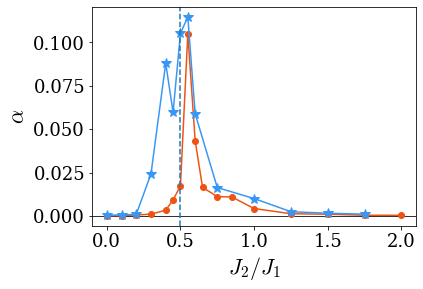

In [53]:
fig, ax = plt.subplots(1, 1, figsize=[6, 4])
ax.axhline(0, lw=0.8, color="black")
ax.plot(cnn_j2s, cnn_anisos, 'o-', color=color1, label='CNN')
ax.plot(rbm_j2s, rbm_anisos, '*-', color=color2, label='RBM', markersize=10)
ax.set_xlabel("$J_2/J_1$", fontsize=22)
ax.set_ylabel("$\\alpha$", fontsize=22)
plt.axvline(0.5, ls='--')
plt.tight_layout()

plt.subplots_adjust(left=0.24, bottom=0.20, right=0.99, top=0.96)
fig.savefig("/mnt/z/Users/Kevin/Pictures/wfh/multi-alpha.png", dpi=300)

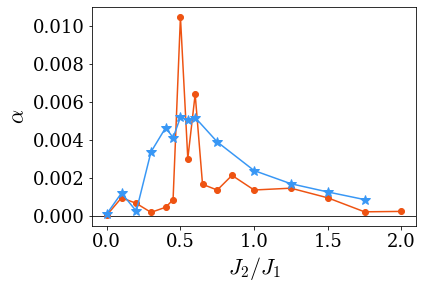

In [11]:
fig, ax = plt.subplots(1, 1, figsize=[6, 4])
ax.axhline(0, lw=0.8, color="black")
ax.plot(cnn_j2s, np.array(cnn_ediff)/16, 'o-', color=color1, label='CNN')
ax.plot(rbm_j2s, np.array(rbm_ediff)/16, '*-', color=color2, label='RBM', markersize=10)
ax.set_xlabel("$J_2/J_1$", fontsize=22)
ax.set_ylabel("$\\alpha$", fontsize=22)

plt.tight_layout()

plt.subplots_adjust(left=0.24, bottom=0.20, right=0.99, top=0.96)
fig.savefig("/mnt/z/Users/Kevin/Pictures/wfh/multi-ediff.png", dpi=300)

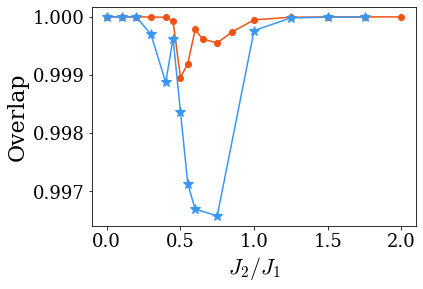

In [12]:
fig, ax = plt.subplots(1, 1, figsize=[6, 4])
ax.plot(cnn_j2s, cnn_overlap_er, 'o-', color=color1, label='CNN')
ax.plot(rbm_j2s, rbm_overlap_er, '*-', color=color2, label='RBM', markersize=10)
ax.set_xlabel("$J_2/J_1$", fontsize=22)
ax.set_ylabel("Overlap", fontsize=22)

plt.tight_layout()

plt.subplots_adjust(left=0.24, bottom=0.20, right=0.99, top=0.96)
fig.savefig("/mnt/z/Users/Kevin/Pictures/wfh/multi-overlap-er.png", dpi=300)

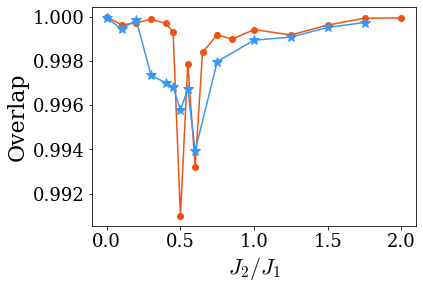

In [13]:
fig, ax = plt.subplots(1, 1, figsize=[6, 4])
ax.plot(cnn_j2s, cnn_overlap_vr, 'o-', color=color1, label='CNN')
ax.plot(rbm_j2s, rbm_overlap_vr, '*-', color=color2, label='RBM', markersize=10)
ax.set_xlabel("$J_2/J_1$", fontsize=22)
ax.set_ylabel("Overlap", fontsize=22)


plt.tight_layout()

plt.subplots_adjust(left=0.24, bottom=0.20, right=0.99, top=0.96)
fig.savefig("/mnt/z/Users/Kevin/Pictures/wfh/multi-overlap-vr.png", dpi=300)

In [23]:
fig, ax = plt.subplots(1, 1, figsize=[6, 4])
ax.plot(cnn_j2s, cnn_overlap_ve, 'o-', color=color1, label='CNN')
ax.plot(rbm_j2s, rbm_overlap_ve, '*-', color=color2, label='RBM', markersize=10)
ax.set_xlabel("$J_2/J_1$", fontsize=22)
ax.set_ylabel("Overlap", fontsize=22)


plt.tight_layout()

plt.subplots_adjust(left=0.24, bottom=0.20, right=0.99, top=0.96)
fig.savefig("/mnt/z/Users/Kevin/Pictures/wfh/multi-overlap-ve.png", dpi=300)

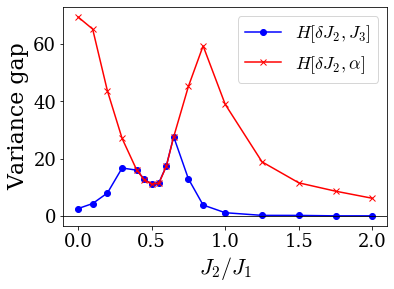

In [35]:
fig, ax = plt.subplots(1, 1, figsize=[6, 4])
ax.plot(cnn_j2s, degen_gap, 'bo-', label="$H[\\delta J_2, J_3]$")
# ax.plot(cnn_j2s, degen_var, 'v-')
ax.plot(cnn_j2s, regular_gap, "rx-", label="$H[\\delta J_2, \\alpha]$")
ax.set_xlabel("$J_2/J_1$", fontsize=22)
ax.axhline(0, lw=0.8, color="black")
ax.set_ylabel("Variance gap", fontsize=22)

plt.legend()
plt.tight_layout()

plt.subplots_adjust(left=0.24, bottom=0.20, right=0.99, top=0.96)
fig.savefig("/mnt/z/Users/Kevin/Pictures/wfh/variance-gap.png", dpi=300)

In [8]:
fig, ax = plt.subplots(1, 1, figsize=[6, 4])
ax.plot(cnn_j2s, degen_dj2, 'o-', label='$\\delta J_2/J_1$')
ax.plot(cnn_j2s, degen_j3, 'x-', label='$J_3/J_1$')
ax.set_xlabel("$J_2/J_1$", fontsize=22)
ax.set_ylabel("Parameter value", fontsize=22)
ax.axhline(0, lw=0.8, color="black")
ax.legend()


plt.tight_layout()

# plt.subplots_adjust(left=0.24, bottom=0.20, right=0.99, top=0.96)
fig.savefig("/mnt/z/Users/Kevin/Pictures/wfh/degen-dj2.png", dpi=300)

In [41]:
fig, ax = plt.subplots(1, 1, figsize=[6, 4])
ax.plot(cnn_j2s, np.array(cnn_var_reg)/(1+np.array(cnn_j2s)**2), 'bo-', label="$H_0$")
ax.plot(cnn_j2s, np.array(cnn_var_recons)/(1+np.array(cnn_j2s)**2), 'ro-', label="$H_R$")
ax.set_xlabel("$J_2/J_1$", fontsize=22)
ax.set_ylabel("$\sigma^2$", fontsize=22)
ax.axhline(0, lw=0.8, color="black")
ax.legend()


plt.tight_layout()

plt.subplots_adjust(left=0.24, bottom=0.20, right=0.99, top=0.96)
fig.savefig("/mnt/z/Users/Kevin/Pictures/wfh/variance.png", dpi=300)

In [51]:
plt.figure(figsize=[6, 4])
plt.plot(cnn_j2s, np.array(cnn_recons_gap)/16, 'ro-', label="Gap $E_1 - E_0$")
plt.errorbar(cnn_j2s, np.array(cnn_ediff_recons)/16, marker='o', ls='-', yerr=np.sqrt(np.array(cnn_var_recons)/(1+np.array(cnn_j2s)**2))/16, color='b', label="$E_{\Psi}$")


plt.axvline(0.5, ls='--')
plt.xlabel("$J_2/J_1$", fontsize=22)
plt.ylabel("$\Delta/N$", fontsize=22)
#plt.gca().tick_params(axis='y', labelcolor='bo-')
#plt.gca().ticklabel_format(scilimits=(0, 0))
plt.gca().set_ylim([0, 0.4])

#ax2 = plt.gca().twinx()
#ax2.plot(common[:, 0], common[:, 3], 'co-')
#ax2.set_ylabel("$\sigma^2$", color='c')
#ax2.tick_params(axis='y', labelcolor='c')
#ax2.set_ylim([0, 1])

plt.tight_layout()
plt.legend()

plt.savefig("/mnt/z/Users/Kevin/Pictures/wfh/gap.png", dpi=300)